In [87]:
import torch

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

In [88]:
import open_clip

def encode_descriptions(class_descriptions):
    # Load CLIP
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model = model.to(DEVICE).eval()

    # Encode the descriptions
    class_names = list(class_descriptions.keys())
    text_descriptions = list(class_descriptions.values())
    with torch.no_grad():
        text_tokens = tokenizer(text_descriptions).to(DEVICE)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    semantics = {class_names[i]: text_features[i] for i in range(len(class_names))}
    return semantics

In [89]:
import json

with open("wn_descriptions.json", 'r') as f:
    cds = json.load(f)

In [90]:
cds

{'apple': 'fruit with red or yellow or green skin and sweet to tart crisp whitish flesh',
 'aquarium_fish': 'a tank or pool or bowl filled with water for keeping live fish and underwater animals',
 'bear': 'massive plantigrade carnivorous or omnivorous mammals with long shaggy coats and strong claws',
 'bee': 'any of numerous hairy-bodied insects including social and solitary species',
 'bottle': 'a glass or plastic vessel used for storing drinks or other liquids; typically cylindrical without handles and with a narrow neck that can be plugged or capped',
 'bowl': 'a round vessel that is open at the top; used chiefly for holding food or liquids',
 'boy': 'a youthful male person',
 'bridge': 'a structure that allows people or vehicles to cross an obstacle such as a river or canal or railway etc.',
 'bus': 'a vehicle carrying many passengers; used for public transport',
 'can': 'airtight sealed metal container for food or drink or paint etc.',
 'castle': 'a large building formerly occupi

In [91]:
default_path = "/Users/jdieguez/Documents/master/TFM/code/TFM-SemFew/Model/semantic/cifar100_semantic_clip_gpt.pth"
semantic = torch.load(default_path, map_location=DEVICE)['semantic_feature']
semantic = {k: v.float() for k, v in semantic.items()}

In [92]:
semantic['train'].shape

torch.Size([512])

In [93]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(encodings, title="2D Visualization"):
    # Convert to a matrix
    class_names = list(encodings.keys())
    vectors = torch.stack([encodings[cls] for cls in class_names])
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
    vectors_2d = tsne.fit_transform(vectors.cpu().numpy())
    
    # Plot
    plt.figure(figsize=(12, 10))
    for i, label in enumerate(class_names):
        x, y = vectors_2d[i]
        plt.scatter(x, y)
        plt.text(x + 0.3, y + 0.3, label, fontsize=8)
    
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

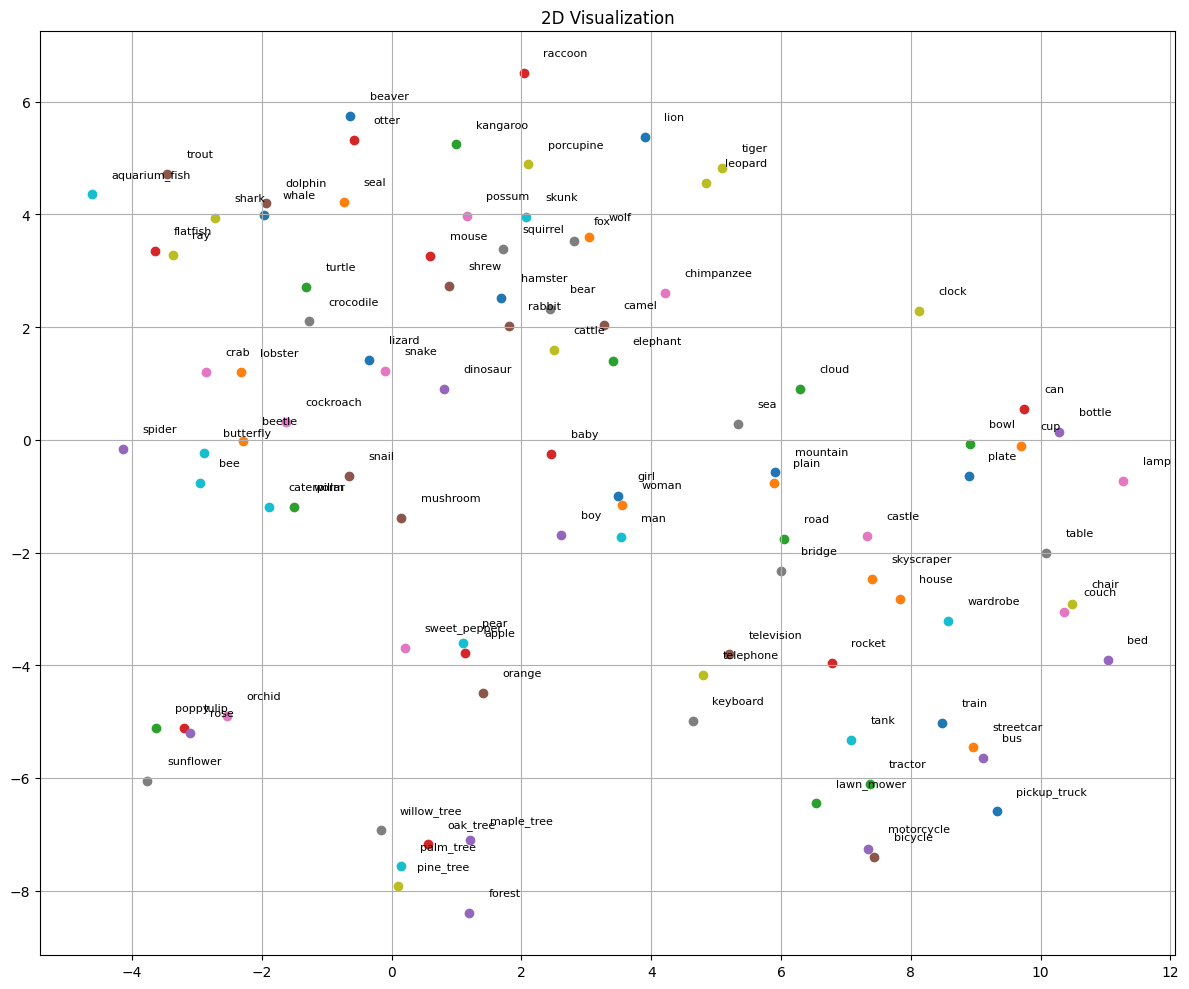

In [94]:
visualize(semantic)

In [115]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

# Interclass entropy with distances
def interclass_entropy(class_encodings, metric='cosine'):
    dists = pdist(class_encodings.cpu().numpy(), metric=metric)
    prob = dists / dists.sum()
    return entropy(prob)

# Interclass entropy based on histogram (focuses more on the shape)
def interclass_entropy_histogram(class_encodings, metric='cosine', bins=50):
    dists = pdist(class_encodings.cpu().numpy(), metric=metric)
    hist, _ = np.histogram(dists, bins=bins, density=True)
    hist += 1e-9  # prevent log(0)
    return entropy(hist, base=2)

In [134]:
def analyze_class_distances(embeddings_dict, k=10, metric='cosine', show=True):
    class_names = list(embeddings_dict.keys())
    encodings = torch.stack([embeddings_dict[cls] for cls in class_names])

    distances = pdist(encodings.cpu().numpy(), metric=metric)
    distance_matrix = squareform(distances)

    # Global statistics
    finite_distances = distances[np.isfinite(distances)]  # safety check
    min_dist = np.min(finite_distances)
    max_dist = np.max(finite_distances)
    mean_dist = np.mean(finite_distances)
    print(f" * Min distance:  {min_dist:.4f}")
    print(f" * Max distance:  {max_dist:.4f}")
    print(f" * Mean distance: {mean_dist:.4f}")

    df = pd.DataFrame(distance_matrix, index=class_names, columns=class_names)

    # Calculate Top k most similar embeddings
    np.fill_diagonal(distance_matrix, np.nan)  # ignore self-distances
    triu_indices = np.triu_indices_from(distance_matrix, k=1)
    sorted_indices = np.argsort(distance_matrix[triu_indices])
    
    top_k_pairs = [(class_names[i], class_names[j], distance_matrix[i, j])
                    for i, j in zip(triu_indices[0][sorted_indices[:k]],
                                    triu_indices[1][sorted_indices[:k]])]

    print("üîç Top k Most Similar Classes:")
    for a, b, d in top_k_pairs:
        print(f" - {a} ‚Üî {b}: {d:.4f}")

    if show:
        # Plot heatmap
        plt.figure(figsize=(20, 16))
        sns.heatmap(df, cmap="viridis", xticklabels=True, yticklabels=True)
        plt.title(f'Pairwise {metric.capitalize()} Distances Between Class Encodings')
        plt.xlabel('Class')
        plt.ylabel('Class')
        plt.tight_layout()
        plt.show()

    return df

üîç Top 20 Most Similar Classes:
 - girl ‚Üî woman: 0.0202
 - dolphin ‚Üî whale: 0.0368
 - snake ‚Üî lizard: 0.0373
 - man ‚Üî woman: 0.0391
 - wolf ‚Üî fox: 0.0404
 - squirrel ‚Üî hamster: 0.0408
 - bear ‚Üî hamster: 0.0413
 - bear ‚Üî rabbit: 0.0422
 - bus ‚Üî streetcar: 0.0425
 - bear ‚Üî cattle: 0.0429
 - caterpillar ‚Üî worm: 0.0448
 - hamster ‚Üî rabbit: 0.0451
 - bottle ‚Üî cup: 0.0454
 - cockroach ‚Üî beetle: 0.0455
 - mountain ‚Üî plain: 0.0475
 - shrew ‚Üî hamster: 0.0478
 - hamster ‚Üî skunk: 0.0479
 - otter ‚Üî beaver: 0.0479
 - possum ‚Üî squirrel: 0.0485
 - pear ‚Üî apple: 0.0487


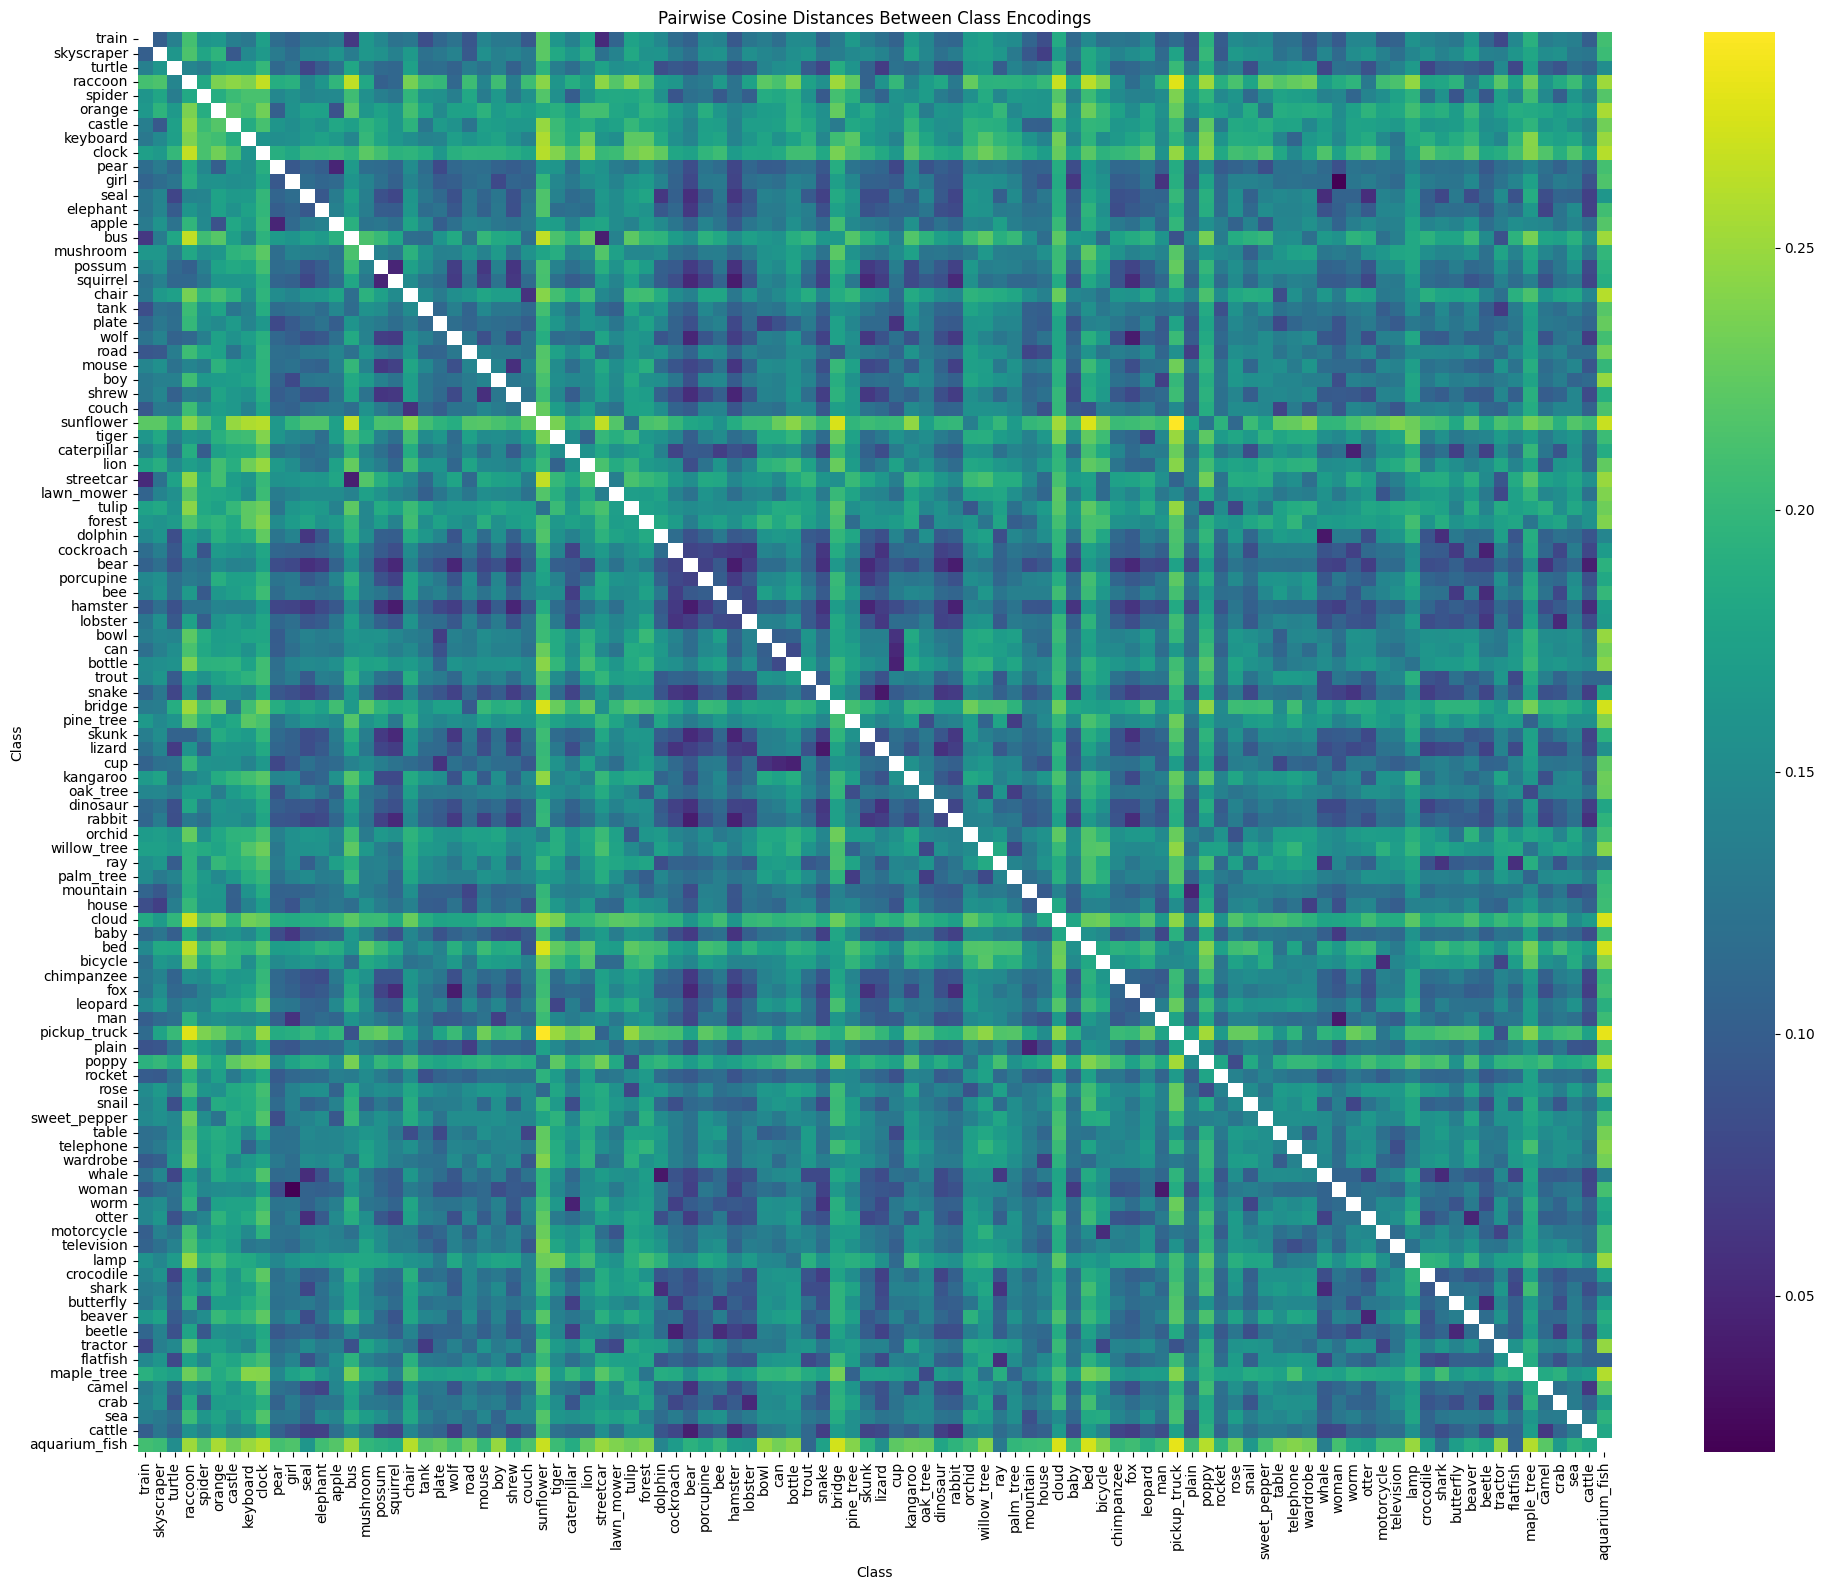

In [97]:
df = analyze_class_distances(semantic)

In [98]:
import torch
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

def cluster_classes(embeddings_dict, metric='cosine', num_clusters=None, distance_threshold=None):
    class_names = list(embeddings_dict.keys())
    encodings = torch.stack([embeddings_dict[cls] for cls in class_names]).cpu().numpy()

    # Pairwise distances
    pairwise_dist = pdist(encodings, metric=metric)

    # Linkage matrix
    Z = linkage(pairwise_dist, method='average')  # Other methods: 'ward', 'single', 'complete'

    # Cluster them with different methods
    if num_clusters:
        clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
    elif distance_threshold:
        clusters = fcluster(Z, t=distance_threshold, criterion='distance')
    else:
        clusters = None  # No cutting, only dendrogram

    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=class_names, leaf_rotation=90)
    plt.title(f'Hierarchical Clustering of Classes ({metric} distance)')
    plt.xlabel('Class')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

    # Print clusters
    if clusters is not None:
        from collections import defaultdict
        cluster_groups = defaultdict(list)
        for cls, cluster_id in zip(class_names, clusters):
            cluster_groups[cluster_id].append(cls)

        print("üîç Clustered Classes:")
        for cluster_id, members in sorted(cluster_groups.items()):
            print(f" - Cluster {cluster_id}: {members}")

        return cluster_groups

    return Z  # return linkage matrix if clusters not formed yet


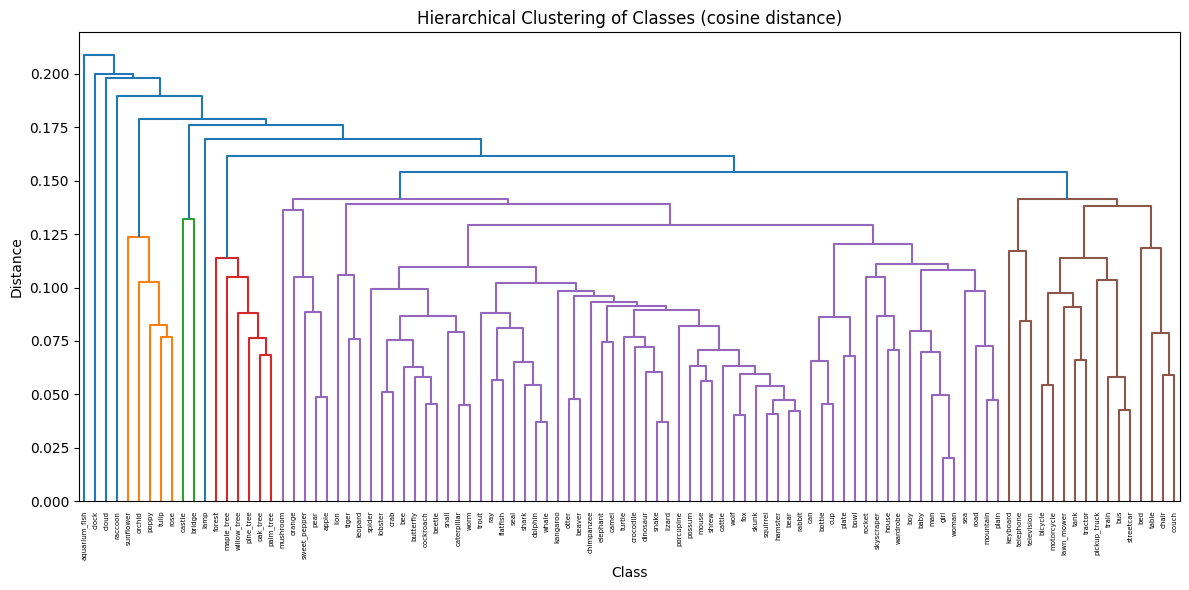

üîç Clustered Classes:
 - Cluster 1: ['sunflower', 'tulip', 'orchid', 'poppy', 'rose']
 - Cluster 2: ['castle', 'bridge']
 - Cluster 3: ['forest', 'pine_tree', 'oak_tree', 'willow_tree', 'palm_tree', 'maple_tree']
 - Cluster 4: ['orange', 'pear', 'apple', 'mushroom', 'sweet_pepper']
 - Cluster 5: ['skyscraper', 'turtle', 'spider', 'girl', 'seal', 'elephant', 'possum', 'squirrel', 'plate', 'wolf', 'road', 'mouse', 'boy', 'shrew', 'tiger', 'caterpillar', 'lion', 'dolphin', 'cockroach', 'bear', 'porcupine', 'bee', 'hamster', 'lobster', 'bowl', 'can', 'bottle', 'trout', 'snake', 'skunk', 'lizard', 'cup', 'kangaroo', 'dinosaur', 'rabbit', 'ray', 'mountain', 'house', 'baby', 'chimpanzee', 'fox', 'leopard', 'man', 'plain', 'rocket', 'snail', 'wardrobe', 'whale', 'woman', 'worm', 'otter', 'crocodile', 'shark', 'butterfly', 'beaver', 'beetle', 'flatfish', 'camel', 'crab', 'sea', 'cattle']
 - Cluster 6: ['keyboard', 'telephone', 'television']
 - Cluster 7: ['train', 'bus', 'chair', 'tank', 'cou

In [99]:
clusters = cluster_classes(semantic, distance_threshold=0.14)

In [100]:
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min

def cluster_classes_kmeans(embeddings_dict, n_clusters=10, metric='cosine'):
    class_names = list(embeddings_dict.keys())
    class_encodings = torch.stack([embeddings_dict[cls] for cls in class_names])
    
    # Normalize encodings for cosine similarity
    norm_encodings = torch.nn.functional.normalize(class_encodings, dim=1)
    
    # KMeans with uses Euclidean distance but normalized
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(norm_encodings.cpu().numpy())

    # Group class names by cluster label
    clustered_classes = {}
    for idx, cluster_id in enumerate(labels):
        clustered_classes.setdefault(cluster_id, []).append(class_names[idx])

    # Cluster summary
    for cluster_id, class_list in clustered_classes.items():
        print(f"Cluster {cluster_id} ({len(class_list)} classes): {class_list}")

    return clustered_classes


In [101]:
clusters = cluster_classes_kmeans(semantic)

Cluster 2 (7 classes): ['train', 'bus', 'chair', 'streetcar', 'bicycle', 'pickup_truck', 'tractor']
Cluster 1 (15 classes): ['skyscraper', 'castle', 'keyboard', 'tank', 'road', 'couch', 'lawn_mower', 'bridge', 'mountain', 'house', 'bed', 'plain', 'rocket', 'wardrobe', 'motorcycle']
Cluster 6 (11 classes): ['turtle', 'seal', 'dolphin', 'trout', 'whale', 'otter', 'crocodile', 'shark', 'beaver', 'sea', 'aquarium_fish']
Cluster 0 (29 classes): ['raccoon', 'girl', 'elephant', 'mushroom', 'possum', 'squirrel', 'wolf', 'mouse', 'boy', 'shrew', 'tiger', 'lion', 'bear', 'porcupine', 'hamster', 'snake', 'skunk', 'lizard', 'kangaroo', 'dinosaur', 'rabbit', 'baby', 'chimpanzee', 'fox', 'leopard', 'man', 'woman', 'camel', 'cattle']
Cluster 5 (8 classes): ['spider', 'caterpillar', 'cockroach', 'bee', 'snail', 'worm', 'butterfly', 'beetle']
Cluster 7 (7 classes): ['orange', 'forest', 'pine_tree', 'oak_tree', 'willow_tree', 'palm_tree', 'maple_tree']
Cluster 4 (13 classes): ['clock', 'pear', 'apple', 

In [117]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_kmeans(embeddings_dict, n_clusters=10, normalize=True, title="KMeans Clusters in 2D Space"):
    class_names = list(embeddings_dict.keys())
    class_encodings = torch.stack([embeddings_dict[cls] for cls in class_names])
    
    if normalize:
        class_encodings = torch.nn.functional.normalize(class_encodings, dim=1)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(class_encodings.cpu().numpy())

    # Reduce to 2D
    #pca = PCA(n_components=2)
    #reduced = pca.fit_transform(class_encodings.cpu().numpy())
    reduced = TSNE(n_components=2).fit_transform(class_encodings.cpu().numpy())

    # Plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_labels, cmap='tab10', s=60)#, edgecolors='k')

    for i, name in enumerate(class_names):
        plt.text(reduced[i, 0], reduced[i, 1], name, fontsize=8, alpha=0.6)
    plt.title(title)
    plt.colorbar(scatter, label="Cluster ID")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    for cluster_id, names in sorted(clusters.items()):
        print(f"Cluster {cluster_id}: {', '.join(names)}")



In [174]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_selected_classes(embeddings_dict, selected_classes, normalize=True, title="Selected Class Embeddings (2D)"):
    # Filter embeddings
    filtered_names = [cls for cls in selected_classes if cls in embeddings_dict]
    if not filtered_names:
        print("No selected classes found in the dictionary.")
        return

    filtered_encodings = torch.stack([embeddings_dict[cls] for cls in filtered_names])

    if normalize:
        filtered_encodings = torch.nn.functional.normalize(filtered_encodings, dim=1)

    # Reduce to 2D using t-SNE
    reduced = TSNE(n_components=2, perplexity=3, random_state=42).fit_transform(filtered_encodings.cpu().numpy())

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=100, c='royalblue')

    for i, name in enumerate(filtered_names):
        plt.text(reduced[i, 0], reduced[i, 1], name, fontsize=12, ha='center', va='center', color='white',
                 bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.3'))

    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


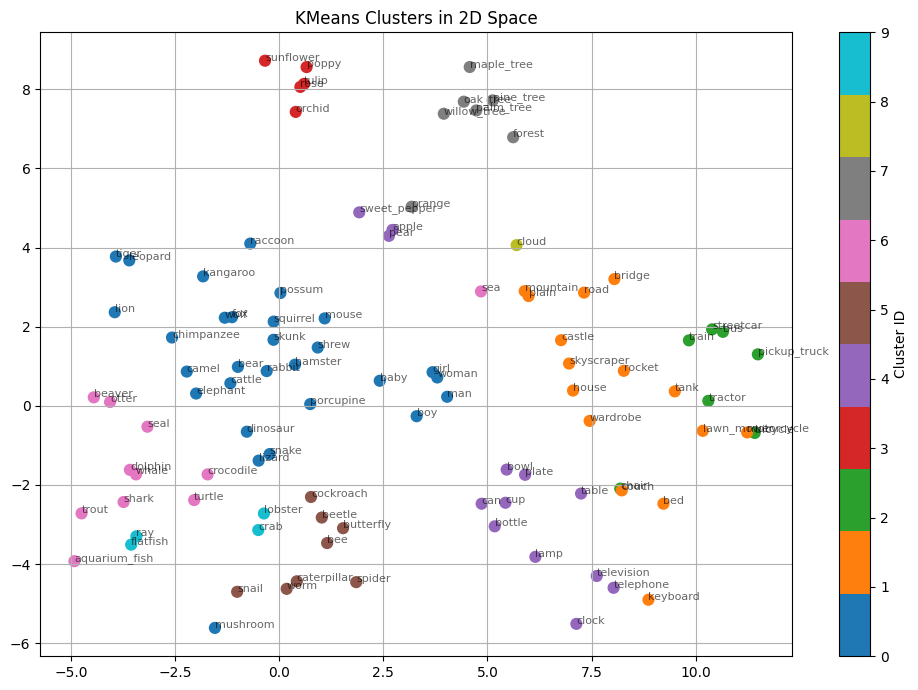

In [103]:
plot_kmeans(semantic)

In [104]:
from scipy.spatial.distance import cdist

def find_k_similar(embeddings_dict, k=5, metric='cosine'):
    class_names = list(embeddings_dict.keys())
    embeddings = torch.stack([embeddings_dict[cls] for cls in class_names])
    
    embeddings = torch.nn.functional.normalize(embeddings, dim=1)
    distances = cdist(embeddings.cpu().numpy(), embeddings.cpu().numpy(), metric=metric)
    
    top_k_dict = {}
    for i, cls in enumerate(class_names):
        sim_indices = np.argsort(distances[i]) 
        top_indices = [j for j in sim_indices if j != i][:k]  # exclude self
        top_k_dict[cls] = [class_names[j] for j in top_indices]

    return top_k_dict

In [146]:
similars_dict = find_k_similar(semantic)
similars_dict

{'apple': ['pear', 'flatfish', 'orange', 'plate', 'sweet_pepper'],
 'aquarium_fish': ['turtle', 'trout', 'flatfish', 'bottle', 'plate'],
 'bear': ['wolf', 'otter', 'fox', 'raccoon', 'porcupine'],
 'bee': ['cockroach', 'butterfly', 'worm', 'beetle', 'caterpillar'],
 'bottle': ['cup', 'bowl', 'table', 'tulip', 'cloud'],
 'bowl': ['bottle', 'cup', 'tractor', 'plate', 'table'],
 'boy': ['girl', 'man', 'woman', 'baby', 'table'],
 'bridge': ['road', 'bus', 'motorcycle', 'mountain', 'house'],
 'bus': ['tractor', 'train', 'road', 'motorcycle', 'pickup_truck'],
 'can': ['cup', 'bottle', 'aquarium_fish', 'bed', 'bowl'],
 'castle': ['skyscraper', 'house', 'mountain', 'bus', 'bowl'],
 'caterpillar': ['butterfly', 'beetle', 'bee', 'porcupine', 'squirrel'],
 'chair': ['couch', 'table', 'bed', 'motorcycle', 'clock'],
 'clock': ['bed', 'television', 'table', 'house', 'mountain'],
 'cloud': ['sea', 'mountain', 'lamp', 'bottle', 'clock'],
 'cockroach': ['bee', 'raccoon', 'butterfly', 'worm', 'beetle'],


In [152]:
with open("most_confused.json", "w") as f:
    json.dump(similars_dict, f, indent=2)

In [184]:
def study_semantics(semantic, title):
    class_names = list(semantic.keys())
    embeddings = torch.stack([semantic[cls] for cls in class_names])
    print(f"Interclass entropy: {interclass_entropy(embeddings)}")
    print(f"Histogram interclass entropy: {interclass_entropy_histogram(embeddings)}")
    plot_kmeans(semantic, title=title)
    #selected_classes = ["boy", "man", "woman", "baby", "girl"]
    #plot_selected_classes(semantic, selected_classes, title=title+" focused")
    
    analyze_class_distances(semantic, show=False)

Interclass entropy: 8.46810501578651
Histogram interclass entropy: 4.92467459531826


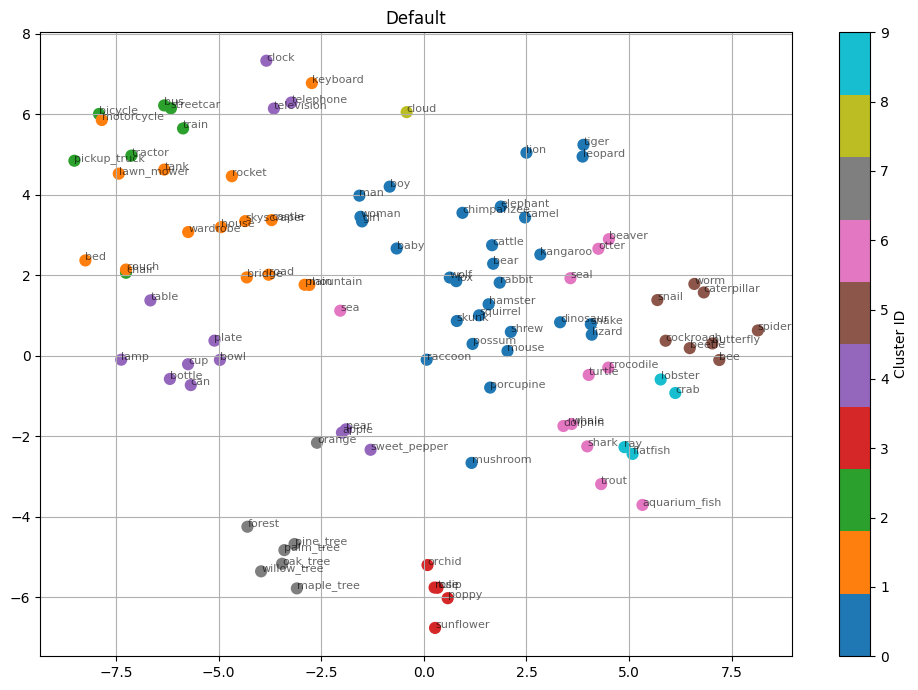

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0202
 * Max distance:  0.2911
 * Mean distance: 0.1453
üîç Top k Most Similar Classes:
 - girl ‚Üî woman: 0.0202
 - dolphin ‚Üî whale: 0.0368
 - snake ‚Üî lizard: 0.0373
 - man ‚Üî woman: 0.0391
 - wolf ‚Üî fox: 0.0404
 - squirrel ‚Üî hamster: 0.0408
 - bear ‚Üî hamster: 0.0413
 - bear ‚Üî rabbit: 0.0422
 - bus ‚Üî streetcar: 0.0425
 - bear ‚Üî cattle: 0.0429


In [188]:
# Default

default_path = "/Users/jdieguez/Documents/master/TFM/code/TFM-SemFew/Model/semantic/cifar100_semantic_clip_gpt.pth"
semantic = torch.load(default_path, map_location=DEVICE)['semantic_feature']
semantic = {k: v.float() for k, v in semantic.items()}

study_semantics(semantic, "Default")

Interclass entropy: 8.477072437739844
Histogram interclass entropy: 4.9770559557881855


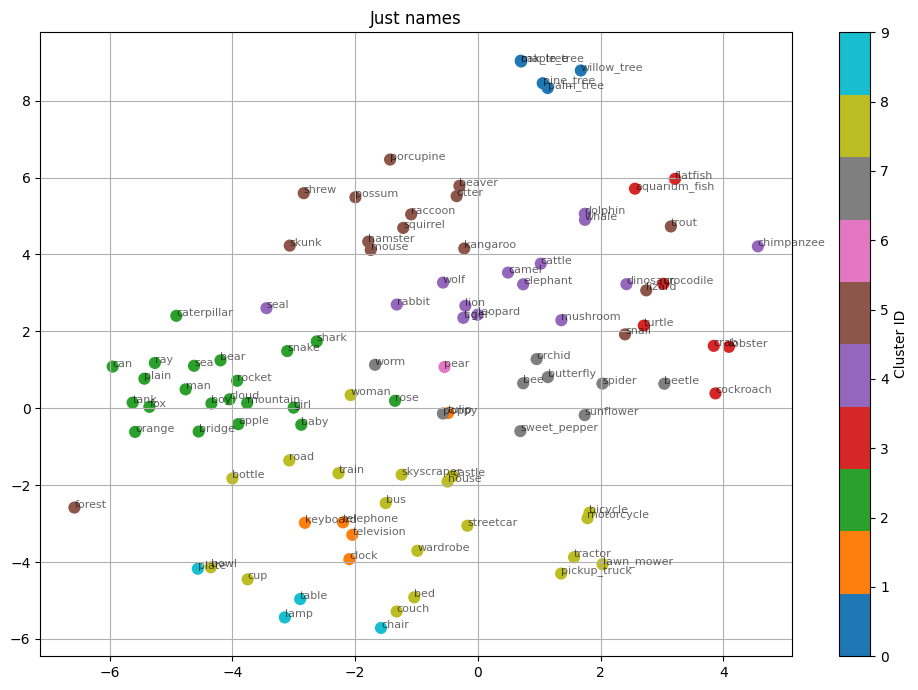

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0958
 * Max distance:  0.6316
 * Mean distance: 0.3428
üîç Top k Most Similar Classes:
 - man ‚Üî plain: 0.0958
 - boy ‚Üî girl: 0.1032
 - boy ‚Üî man: 0.1043
 - cloud ‚Üî mountain: 0.1054
 - mountain ‚Üî man: 0.1055
 - boy ‚Üî ray: 0.1097
 - bear ‚Üî man: 0.1119
 - boy ‚Üî baby: 0.1125
 - girl ‚Üî baby: 0.1131
 - sea ‚Üî man: 0.1168


In [189]:
# With names
class_names = ['apple', 'aquarium_fish', 'bear', 'bee', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'can', 'castle', 'caterpillar', 'chair', 'clock', 'cloud', 'cockroach', 'couch', 'cup', 'dinosaur', 'dolphin', 'elephant', 'forest', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lawn_mower', 'lion', 'lizard', 'lobster', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'palm_tree', 'pear', 'pine_tree', 'plate', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'seal', 'shrew', 'skunk', 'skyscraper', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'tank', 'tiger', 'train', 'trout', 'tulip', 'turtle', 'willow_tree', 'wolf', 'beaver', 'beetle', 'butterfly', 'camel', 'cattle', 'crab', 'crocodile', 'flatfish', 'lamp', 'maple_tree', 'motorcycle', 'otter', 'sea', 'shark', 'television', 'tractor', 'baby', 'bed', 'bicycle', 'chimpanzee', 'fox', 'leopard', 'man', 'pickup_truck', 'plain', 'poppy', 'rocket', 'rose', 'snail', 'sweet_pepper', 'table', 'telephone', 'wardrobe', 'whale', 'woman', 'worm']
class_descriptions = {cls:cls for cls in class_names}
semantic = encode_descriptions(class_descriptions)
study_semantics(semantic, "Just names")

In [190]:
def study_from_file(file, title):
    with open(file, 'r') as f:
        cds = json.load(f)
    semantic = encode_descriptions(cds)
    
    study_semantics(semantic, title)

Interclass entropy: 8.491220921652165
Histogram interclass entropy: 4.719907369958058


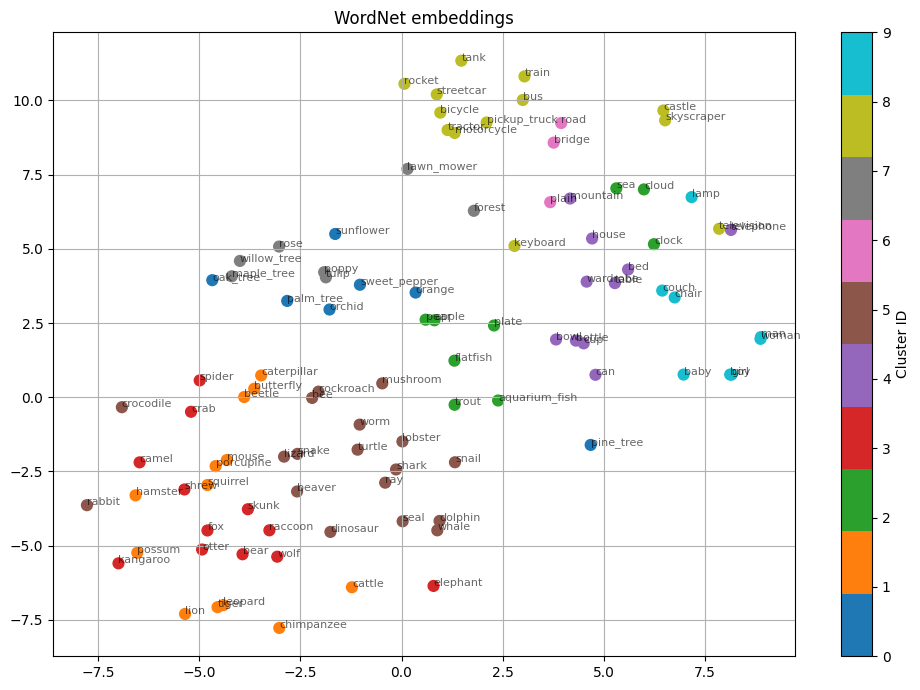

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0593
 * Max distance:  0.6266
 * Mean distance: 0.4226
üîç Top k Most Similar Classes:
 - man ‚Üî woman: 0.0593
 - tiger ‚Üî leopard: 0.0753
 - tulip ‚Üî poppy: 0.0788
 - boy ‚Üî girl: 0.1003
 - tractor ‚Üî bicycle: 0.1583
 - streetcar ‚Üî bicycle: 0.1602
 - motorcycle ‚Üî bicycle: 0.1606
 - motorcycle ‚Üî tractor: 0.1620
 - caterpillar ‚Üî butterfly: 0.1660
 - apple ‚Üî pear: 0.1687


In [191]:
# Wordnet descriptions

study_from_file("wn_descriptions.json", "WordNet embeddings")

Interclass entropy: 8.482092754571214
Histogram interclass entropy: 4.948115330464122


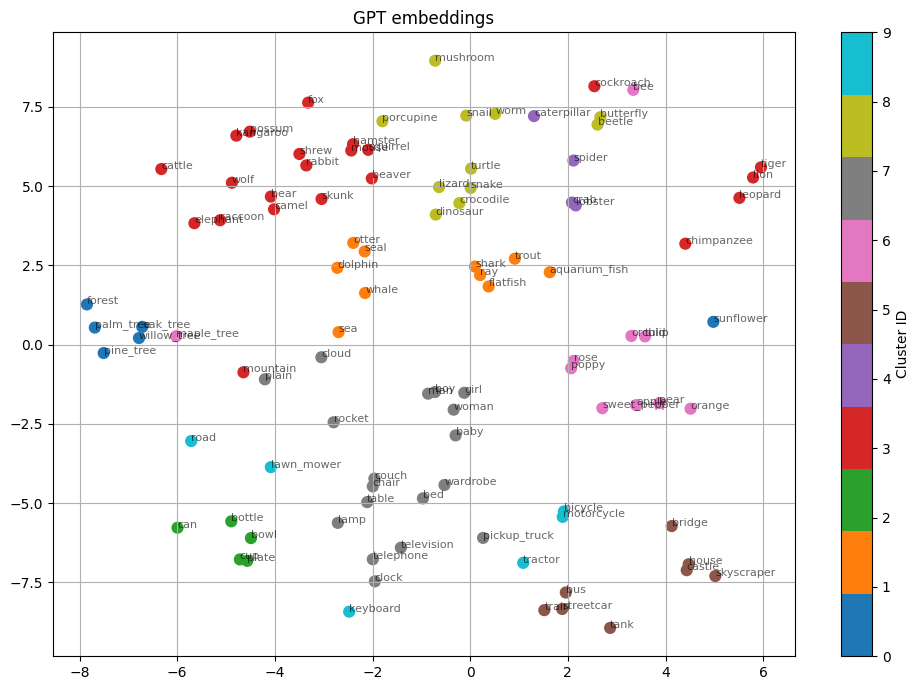

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0743
 * Max distance:  0.6458
 * Mean distance: 0.3957
üîç Top k Most Similar Classes:
 - hamster ‚Üî mouse: 0.0743
 - hamster ‚Üî squirrel: 0.0743
 - mouse ‚Üî squirrel: 0.0775
 - lobster ‚Üî crab: 0.0915
 - bear ‚Üî camel: 0.1046
 - rabbit ‚Üî shrew: 0.1050
 - boy ‚Üî man: 0.1064
 - mouse ‚Üî rabbit: 0.1156
 - hamster ‚Üî rabbit: 0.1162
 - kangaroo ‚Üî possum: 0.1195


In [192]:
study_from_file("gpt_descriptions.json", "GPT embeddings")

Interclass entropy: 8.488234371164541
Histogram interclass entropy: 4.862796313340406


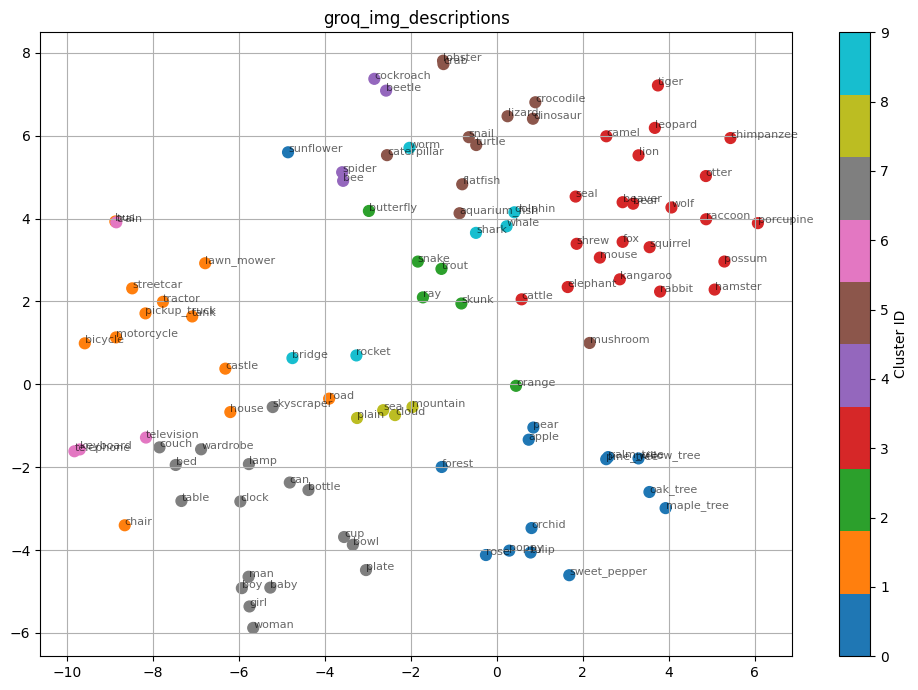

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1355
 * Max distance:  0.6708
 * Mean distance: 0.3936
üîç Top k Most Similar Classes:
 - lobster ‚Üî crab: 0.1355
 - palm_tree ‚Üî pine_tree: 0.1449
 - shark ‚Üî whale: 0.1474
 - trout ‚Üî shark: 0.1540
 - mouse ‚Üî shrew: 0.1579
 - boy ‚Üî man: 0.1622
 - bear ‚Üî beaver: 0.1711
 - bee ‚Üî spider: 0.1720
 - bowl ‚Üî cup: 0.1720
 - mouse ‚Üî fox: 0.1723


In [193]:
study_from_file("groq_img_descriptions.json", "groq_img_descriptions")

Interclass entropy: 8.48266384782966
Histogram interclass entropy: 4.701767839253125


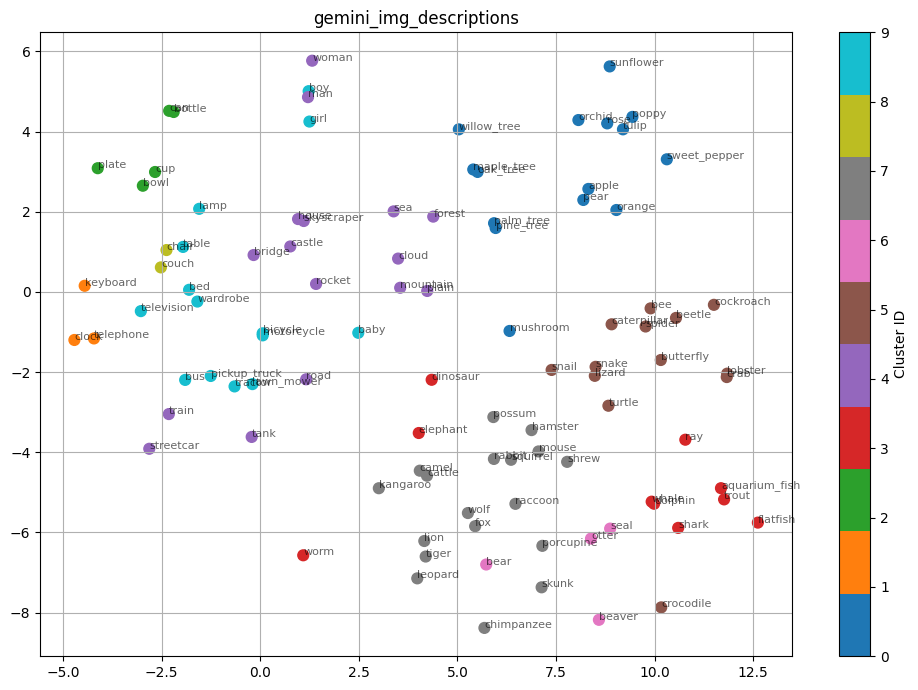

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1280
 * Max distance:  0.7810
 * Mean distance: 0.3842
üîç Top k Most Similar Classes:
 - dolphin ‚Üî whale: 0.1280
 - tractor ‚Üî pickup_truck: 0.1434
 - chair ‚Üî table: 0.1449
 - motorcycle ‚Üî bicycle: 0.1492
 - wolf ‚Üî fox: 0.1494
 - lizard ‚Üî snake: 0.1533
 - rabbit ‚Üî squirrel: 0.1540
 - chair ‚Üî couch: 0.1570
 - lion ‚Üî tiger: 0.1590
 - spider ‚Üî beetle: 0.1622


In [194]:
study_from_file("gemini_img_descriptions.json", "gemini_img_descriptions")

Interclass entropy: 8.485353408236945
Histogram interclass entropy: 4.888673318110951


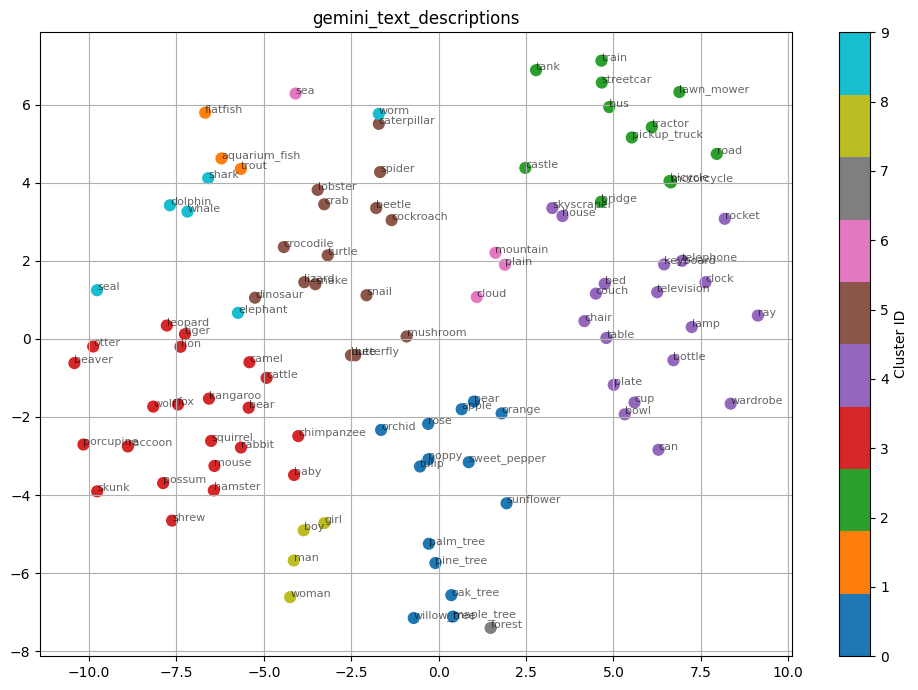

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1300
 * Max distance:  0.6940
 * Mean distance: 0.3947
üîç Top k Most Similar Classes:
 - lion ‚Üî tiger: 0.1300
 - mouse ‚Üî squirrel: 0.1366
 - motorcycle ‚Üî bicycle: 0.1368
 - lobster ‚Üî crab: 0.1378
 - lion ‚Üî leopard: 0.1482
 - bowl ‚Üî cup: 0.1531
 - palm_tree ‚Üî pine_tree: 0.1537
 - tiger ‚Üî leopard: 0.1538
 - wolf ‚Üî fox: 0.1566
 - hamster ‚Üî mouse: 0.1569


In [195]:
study_from_file("gemini_text_descriptions.json", "gemini_text_descriptions")

Interclass entropy: 8.4873647393041
Histogram interclass entropy: 4.875693571195437


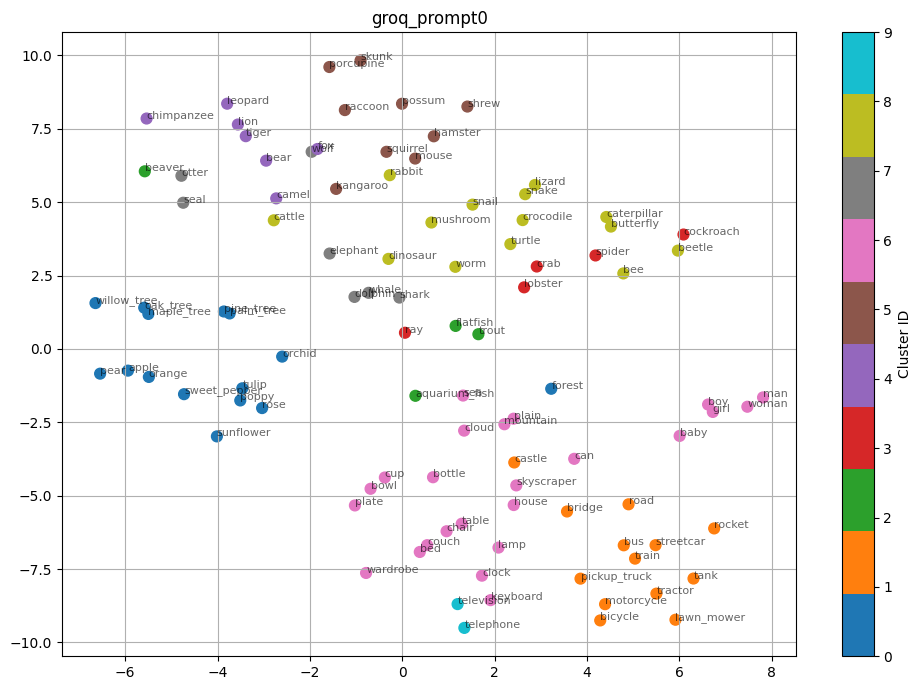

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1180
 * Max distance:  0.6149
 * Mean distance: 0.3595
üîç Top k Most Similar Classes:
 - couch ‚Üî bed: 0.1180
 - boy ‚Üî girl: 0.1190
 - chair ‚Üî table: 0.1235
 - chair ‚Üî couch: 0.1310
 - girl ‚Üî woman: 0.1315
 - mountain ‚Üî plain: 0.1375
 - palm_tree ‚Üî pine_tree: 0.1420
 - bowl ‚Üî cup: 0.1478
 - dolphin ‚Üî whale: 0.1480
 - motorcycle ‚Üî bicycle: 0.1491


In [196]:
study_from_file("groq_prompt0.json", "groq_prompt0")

Interclass entropy: 8.486669277052979
Histogram interclass entropy: 4.975320557099978


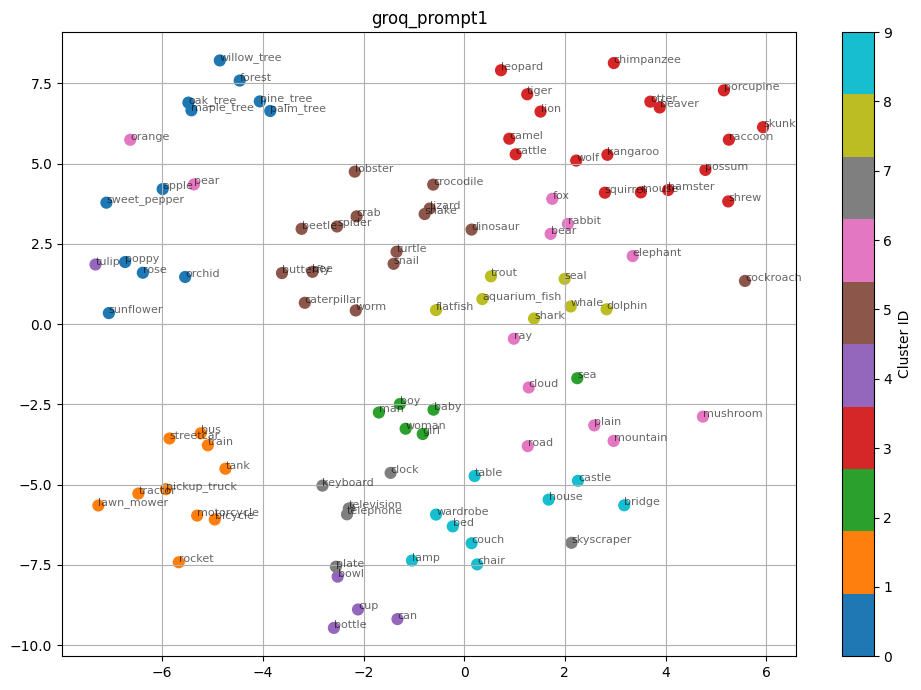

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1073
 * Max distance:  0.5728
 * Mean distance: 0.3586
üîç Top k Most Similar Classes:
 - girl ‚Üî woman: 0.1073
 - boy ‚Üî man: 0.1198
 - bear ‚Üî rabbit: 0.1272
 - boy ‚Üî baby: 0.1300
 - man ‚Üî woman: 0.1373
 - girl ‚Üî baby: 0.1381
 - lizard ‚Üî snake: 0.1385
 - boy ‚Üî girl: 0.1397
 - mouse ‚Üî squirrel: 0.1402
 - boy ‚Üî woman: 0.1444


In [197]:
study_from_file("groq_prompt1.json", "groq_prompt1")

Interclass entropy: 8.488848999645661
Histogram interclass entropy: 4.749045875853667


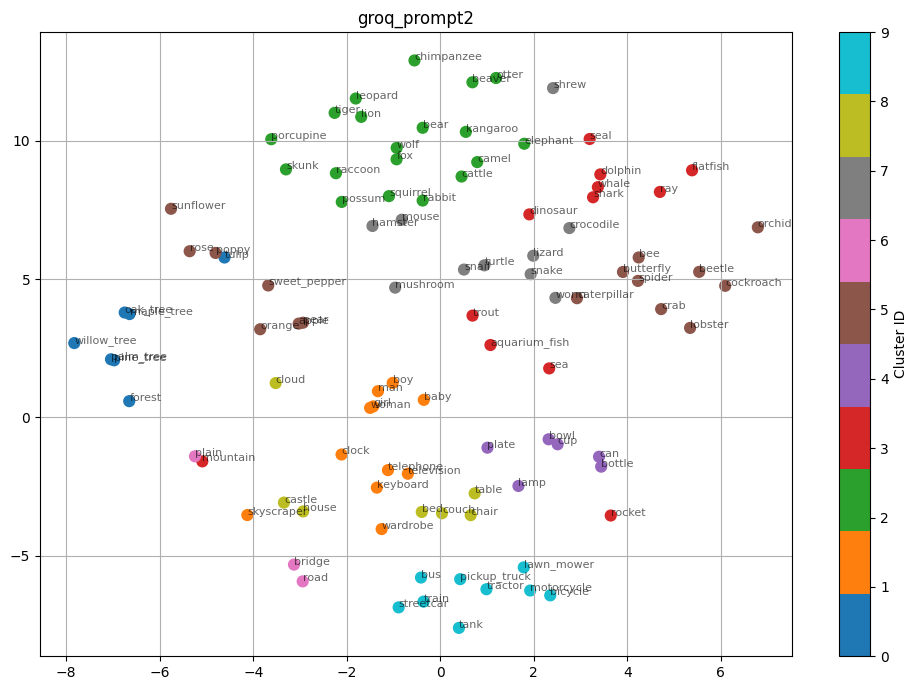

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0924
 * Max distance:  0.5834
 * Mean distance: 0.3423
üîç Top k Most Similar Classes:
 - girl ‚Üî woman: 0.0924
 - man ‚Üî woman: 0.1135
 - couch ‚Üî bed: 0.1180
 - boy ‚Üî man: 0.1189
 - motorcycle ‚Üî bicycle: 0.1201
 - bowl ‚Üî cup: 0.1285
 - shark ‚Üî whale: 0.1296
 - chair ‚Üî couch: 0.1326
 - dolphin ‚Üî whale: 0.1346
 - girl ‚Üî man: 0.1347


In [198]:
study_from_file("groq_prompt2.json", "groq_prompt2")

Interclass entropy: 8.487555702898089
Histogram interclass entropy: 4.8819239972909525


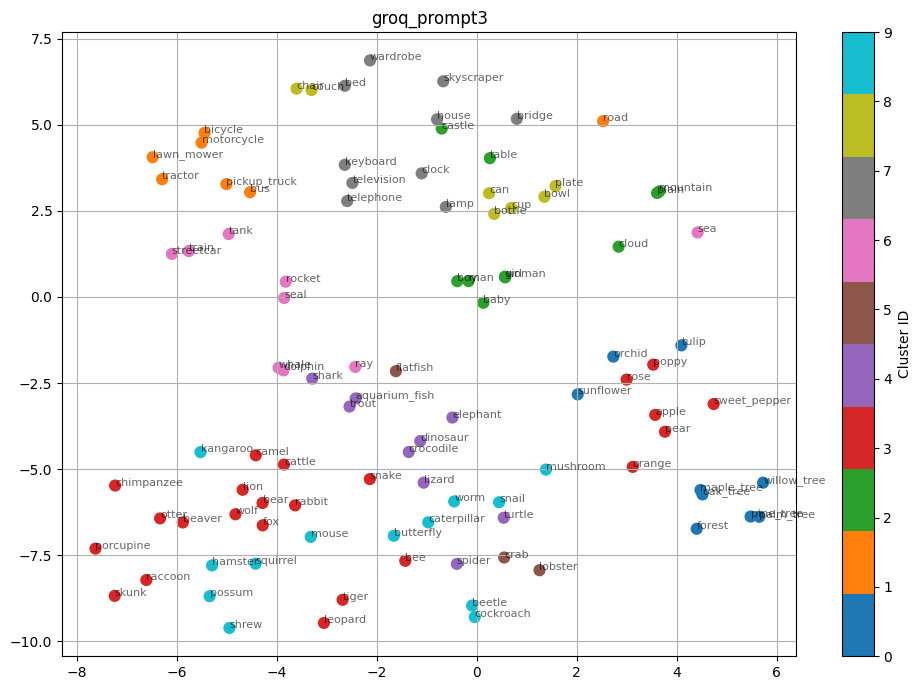

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1084
 * Max distance:  0.6154
 * Mean distance: 0.3719
üîç Top k Most Similar Classes:
 - girl ‚Üî woman: 0.1084
 - bear ‚Üî rabbit: 0.1393
 - man ‚Üî woman: 0.1413
 - boy ‚Üî man: 0.1416
 - bear ‚Üî wolf: 0.1456
 - bear ‚Üî cattle: 0.1488
 - oak_tree ‚Üî maple_tree: 0.1496
 - bottle ‚Üî cup: 0.1510
 - boy ‚Üî girl: 0.1517
 - wolf ‚Üî fox: 0.1524


In [199]:
study_from_file("groq_prompt3.json", "groq_prompt3")

Interclass entropy: 8.485736402700434
Histogram interclass entropy: 4.85112881173244


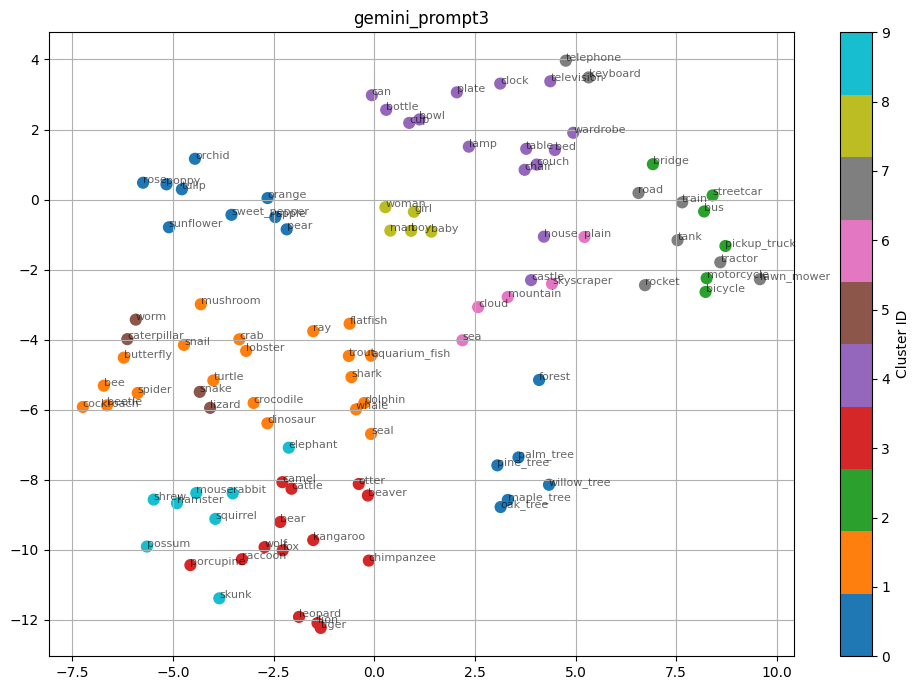

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1128
 * Max distance:  0.6663
 * Mean distance: 0.3818
üîç Top k Most Similar Classes:
 - bowl ‚Üî cup: 0.1128
 - raccoon ‚Üî wolf: 0.1181
 - chair ‚Üî couch: 0.1218
 - bear ‚Üî wolf: 0.1335
 - tulip ‚Üî poppy: 0.1420
 - bottle ‚Üî cup: 0.1420
 - motorcycle ‚Üî bicycle: 0.1434
 - lion ‚Üî tiger: 0.1435
 - lizard ‚Üî snake: 0.1447
 - couch ‚Üî bed: 0.1447


In [200]:
study_from_file("gemini_prompt3.json", "gemini_prompt3")

Interclass entropy: 8.479821060141697
Histogram interclass entropy: 4.651788187543152


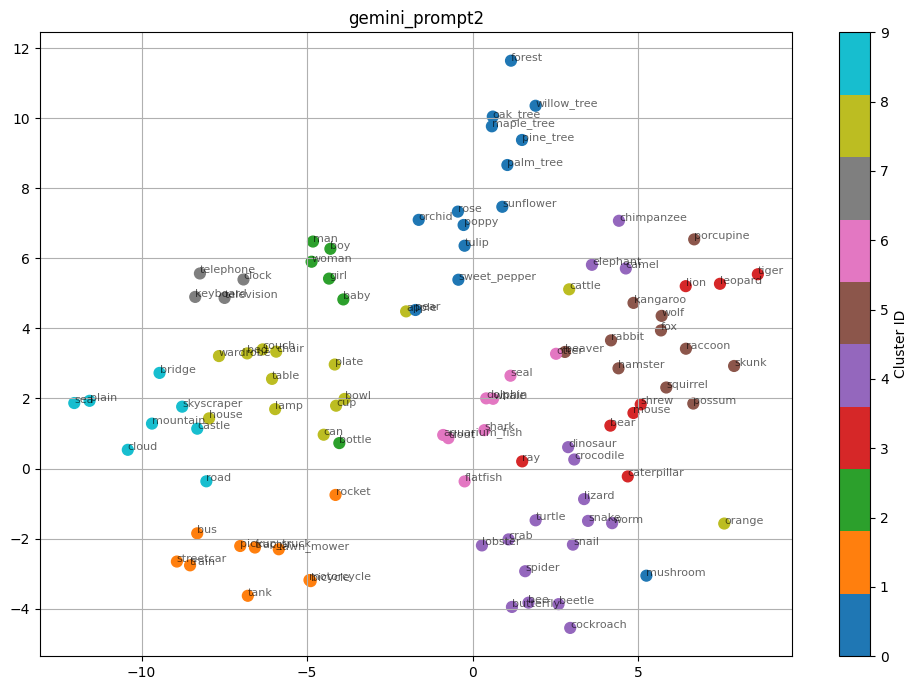

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0747
 * Max distance:  0.7201
 * Mean distance: 0.3654
üîç Top k Most Similar Classes:
 - mouse ‚Üî shrew: 0.0747
 - couch ‚Üî bed: 0.1213
 - girl ‚Üî woman: 0.1270
 - man ‚Üî woman: 0.1271
 - motorcycle ‚Üî bicycle: 0.1321
 - bowl ‚Üî cup: 0.1336
 - boy ‚Üî man: 0.1342
 - chair ‚Üî couch: 0.1369
 - dolphin ‚Üî whale: 0.1399
 - wolf ‚Üî fox: 0.1426


In [201]:
study_from_file("gemini_prompt2.json", "gemini_prompt2")

Interclass entropy: 8.485139592185913
Histogram interclass entropy: 4.875756024160694


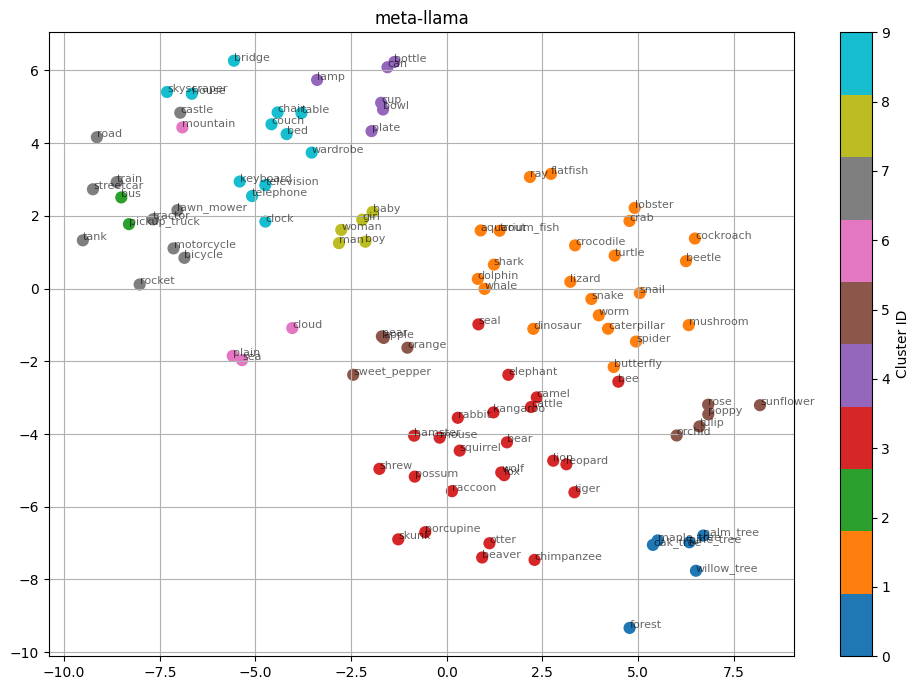

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0977
 * Max distance:  0.5955
 * Mean distance: 0.3439
üîç Top k Most Similar Classes:
 - bowl ‚Üî cup: 0.0977
 - man ‚Üî woman: 0.1169
 - apple ‚Üî pear: 0.1238
 - motorcycle ‚Üî bicycle: 0.1294
 - couch ‚Üî bed: 0.1309
 - chair ‚Üî couch: 0.1329
 - mouse ‚Üî squirrel: 0.1355
 - bus ‚Üî train: 0.1362
 - girl ‚Üî woman: 0.1398
 - chair ‚Üî table: 0.1407


In [202]:
study_from_file("meta-llama_llama-4-scout:free_descriptions.json", "meta-llama_scout")

Interclass entropy: 8.486089584528845
Histogram interclass entropy: 4.872883823270782


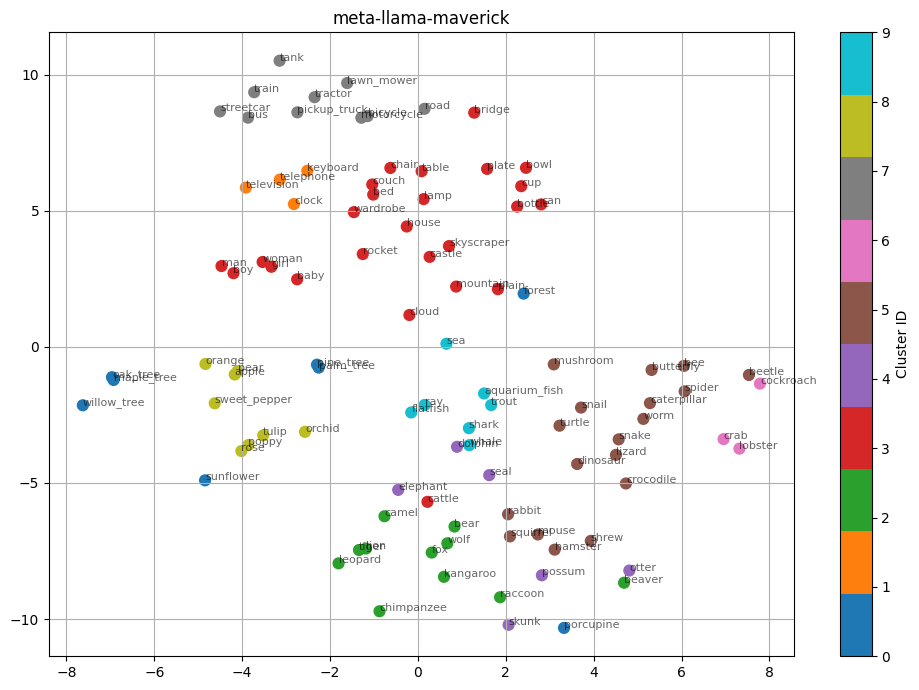

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0791
 * Max distance:  0.5525
 * Mean distance: 0.3349
üîç Top k Most Similar Classes:
 - girl ‚Üî woman: 0.0791
 - boy ‚Üî man: 0.1015
 - couch ‚Üî bed: 0.1040
 - boy ‚Üî girl: 0.1122
 - man ‚Üî woman: 0.1278
 - apple ‚Üî pear: 0.1282
 - oak_tree ‚Üî maple_tree: 0.1313
 - shark ‚Üî whale: 0.1314
 - mouse ‚Üî squirrel: 0.1315
 - girl ‚Üî baby: 0.1387


In [204]:
study_from_file("meta-llama_llama-4-maverick:free_descriptions.json", "meta-llama-maverick")

Interclass entropy: 8.486387601869133
Histogram interclass entropy: 4.762257882199289


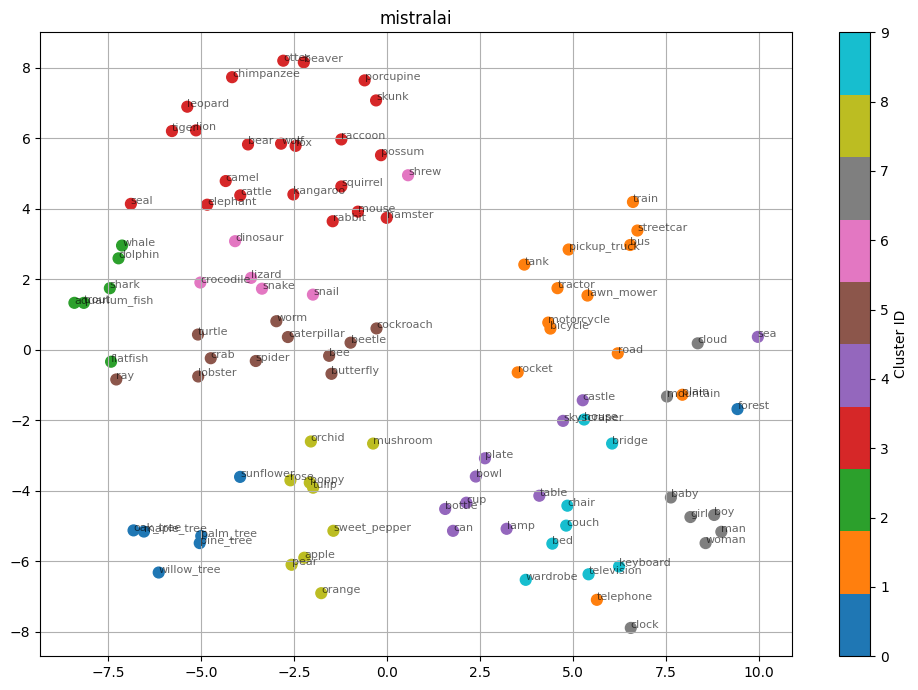

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1051
 * Max distance:  0.6659
 * Mean distance: 0.3709
üîç Top k Most Similar Classes:
 - motorcycle ‚Üî bicycle: 0.1051
 - boy ‚Üî man: 0.1308
 - man ‚Üî woman: 0.1373
 - boy ‚Üî girl: 0.1398
 - mouse ‚Üî squirrel: 0.1423
 - bowl ‚Üî cup: 0.1426
 - girl ‚Üî woman: 0.1469
 - lizard ‚Üî snake: 0.1478
 - wolf ‚Üî fox: 0.1577
 - oak_tree ‚Üî maple_tree: 0.1610


In [205]:
study_from_file("mistralai_mistral-small-3.1-24b-instruct:free_descriptions.json", "mistralai")

Interclass entropy: 8.488413928129116
Histogram interclass entropy: 4.867934292161102


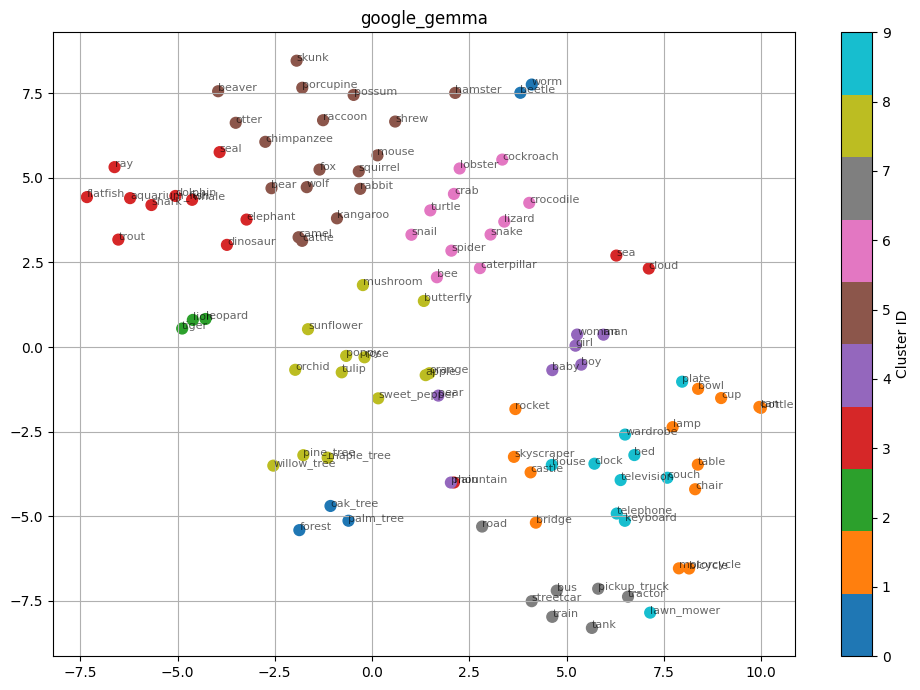

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0974
 * Max distance:  0.5956
 * Mean distance: 0.3704
üîç Top k Most Similar Classes:
 - girl ‚Üî woman: 0.0974
 - motorcycle ‚Üî bicycle: 0.1294
 - boy ‚Üî girl: 0.1390
 - mountain ‚Üî plain: 0.1508
 - bee ‚Üî spider: 0.1520
 - wolf ‚Üî fox: 0.1544
 - rabbit ‚Üî squirrel: 0.1555
 - couch ‚Üî bed: 0.1561
 - mouse ‚Üî squirrel: 0.1621
 - camel ‚Üî cattle: 0.1641


In [206]:
study_from_file("google_gemma-3-27b-it:free_descriptions.json", "google_gemma")

Interclass entropy: 8.487430701852688
Histogram interclass entropy: 4.780754962796209


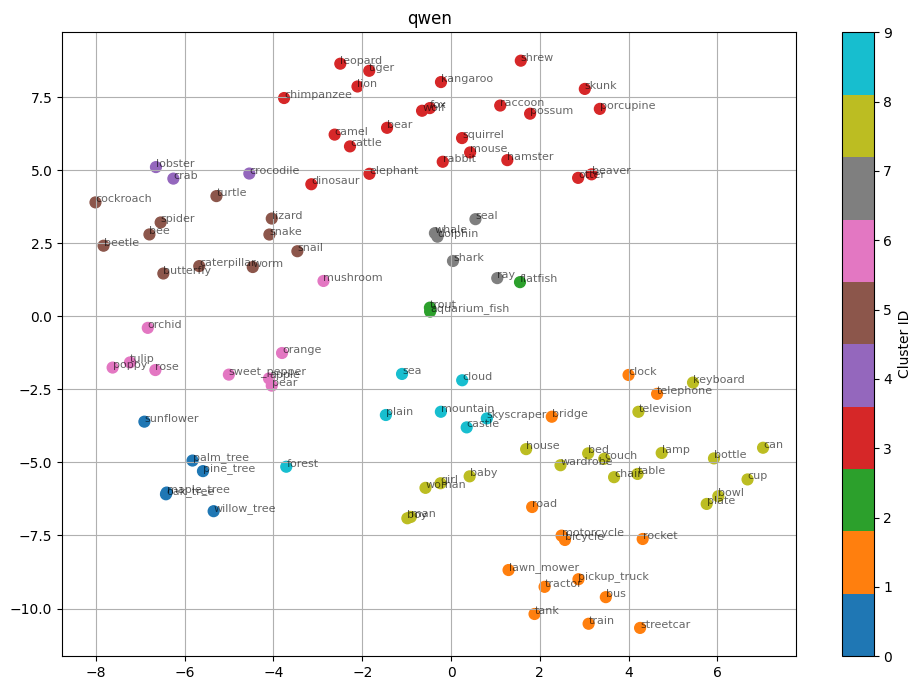

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.0829
 * Max distance:  0.6109
 * Mean distance: 0.3594
üîç Top k Most Similar Classes:
 - girl ‚Üî woman: 0.0829
 - boy ‚Üî man: 0.1094
 - couch ‚Üî bed: 0.1118
 - chair ‚Üî couch: 0.1191
 - bowl ‚Üî plate: 0.1334
 - motorcycle ‚Üî bicycle: 0.1393
 - chair ‚Üî table: 0.1428
 - man ‚Üî woman: 0.1429
 - mouse ‚Üî squirrel: 0.1454
 - dolphin ‚Üî whale: 0.1464


In [207]:
study_from_file("qwen_qwen2.5-vl-72b-instruct:free_descriptions.json", "qwen")

Interclass entropy: 8.48541046849279
Histogram interclass entropy: 4.834889046861192


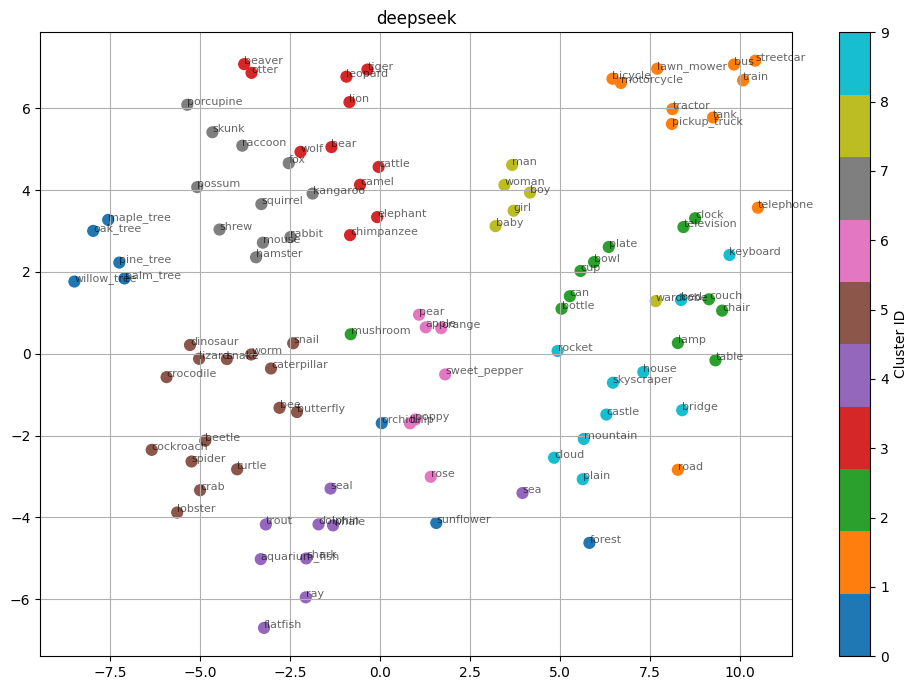

Cluster 0: raccoon, girl, elephant, mushroom, possum, squirrel, wolf, mouse, boy, shrew, tiger, lion, bear, porcupine, hamster, snake, skunk, lizard, kangaroo, dinosaur, rabbit, baby, chimpanzee, fox, leopard, man, woman, camel, cattle
Cluster 1: skyscraper, castle, keyboard, tank, road, couch, lawn_mower, bridge, mountain, house, bed, plain, rocket, wardrobe, motorcycle
Cluster 2: train, bus, chair, streetcar, bicycle, pickup_truck, tractor
Cluster 3: sunflower, tulip, orchid, poppy, rose
Cluster 4: clock, pear, apple, plate, bowl, can, bottle, cup, sweet_pepper, table, telephone, television, lamp
Cluster 5: spider, caterpillar, cockroach, bee, snail, worm, butterfly, beetle
Cluster 6: turtle, seal, dolphin, trout, whale, otter, crocodile, shark, beaver, sea, aquarium_fish
Cluster 7: orange, forest, pine_tree, oak_tree, willow_tree, palm_tree, maple_tree
Cluster 8: cloud
Cluster 9: lobster, ray, flatfish, crab


 * Min distance:  0.1135
 * Max distance:  0.6737
 * Mean distance: 0.3802
üîç Top k Most Similar Classes:
 - girl ‚Üî woman: 0.1135
 - man ‚Üî woman: 0.1282
 - boy ‚Üî girl: 0.1388
 - bowl ‚Üî cup: 0.1408
 - tractor ‚Üî pickup_truck: 0.1430
 - chair ‚Üî couch: 0.1464
 - wolf ‚Üî fox: 0.1491
 - mouse ‚Üî squirrel: 0.1512
 - motorcycle ‚Üî bicycle: 0.1538
 - dolphin ‚Üî whale: 0.1578


In [208]:
study_from_file("deepseek_deepseek-r1:free_descriptions.json", "deepseek")